# Market Making Signal Generation from Orderbook Imbalance

### Load the data and calculate the imbalance

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('binance-futures_book_snapshot_25_2019-11-17_BTCUSDT.csv')
df = df.drop(columns = ['exchange', 'symbol', 'timestamp', 'local_timestamp'])

df['total_asks_amount'] = df[[f'asks[{i}].amount' for i in range(25)]].sum(axis=1)
df['total_bids_amount'] = df[[f'bids[{i}].amount' for i in range(25)]].sum(axis=1)
df['imbalance'] = (df['total_bids_amount'] - df['total_asks_amount']) / (df['total_bids_amount'] + df['total_asks_amount'])
'''
Imbalance values:
    -> -1 = total_asks_amount is much larger than total_bids_amount
    -> 0 = total_asks_amount is the same as total_bids_amount
    -> 1 = total_bids_amount is much larger than total_asks_amount
'''

print(df)

        asks[0].price  asks[0].amount  bids[0].price  bids[0].amount  \
0             8492.16           0.367        8491.19           0.007   
1             8493.08           1.118        8493.01           0.478   
2             8493.02           0.034        8493.01           0.478   
3             8493.01           0.400        8493.00          18.316   
4             8493.01           1.100        8493.00          18.316   
...               ...             ...            ...             ...   
470302        8504.04           0.100        8504.03           0.500   
470303        8504.87           0.034        8504.02           0.677   
470304        8504.86           0.004        8504.03           0.026   
470305        8504.86           0.004        8504.03           0.026   
470306        8504.86           0.004        8504.03           0.026   

        asks[1].price  asks[1].amount  bids[1].price  bids[1].amount  \
0             8492.17           0.542        8491.18           

### Plot the imbalance

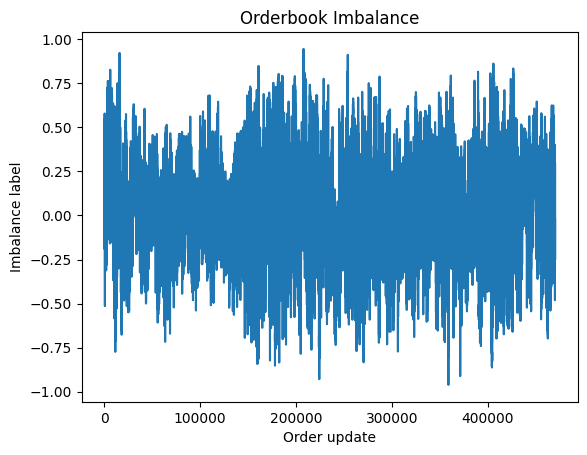

In [27]:
plt.title("Orderbook Imbalance")
plt.xlabel("Order update")
plt.ylabel("Imbalance label")
plt.plot(df['imbalance'])

### Market Making Basic Steps:
#### 1. Monitor the orderbook imbalance. If the imabalnce exceeds a threshold in either direction (hyperparameter to be tuned later), generate a signal towards the side of the imbalance.
#### 2. If the signal generated indicates a larger total asks amount (indicating a downward movement in prices), generate a buy (long) signal and if the signal indicates a larger total buy amount (indicating an upward movement in prices), generate a sell (short) signal. The role of a market maker is to maintain market stability by slowing down these price trends and returning to equilibrium.

In [24]:
threshold = 0.7
df['signal'] = 0

for i in range(1, len(df)):
    if abs(df['imbalance'][i]) > threshold:
        # Imbalance
        if(df['imbalance'][i] > 0):
            # Bid side imbalance -> short signal
            df.loc[i, 'signal'] = -1
        else:
            # Ask side imbalance -> long signal
            df.loc[i, 'signal'] = 1
    else:
        # No Imbalance
        df.loc[i, 'signal'] = 0

In [25]:
print("Long Signal:")
print(df.index[df['signal'] == 1].tolist())  #long signal
print("\n---------------------------------------------------------------------------------------------------------\n")
print("Short Signal:")
print(df.index[df['signal'] == -1].tolist())  #Short signal

Long Signal:
[11594, 11595, 11596, 11617, 11812, 11813, 11814, 63577, 153636, 153637, 153638, 153640, 153641, 155937, 158630, 158632, 158633, 158701, 158714, 158792, 158794, 158827, 158829, 159407, 159408, 159412, 159477, 159479, 159480, 159481, 159482, 159669, 159681, 159683, 160372, 160374, 160389, 160392, 160394, 160929, 160930, 160931, 160932, 160959, 160960, 160961, 160962, 160963, 160964, 172923, 172924, 178103, 178108, 178109, 178110, 178111, 178131, 178132, 178134, 178135, 178138, 178152, 178937, 180378, 180379, 180380, 180382, 182564, 182565, 182566, 182567, 182568, 182569, 182570, 182571, 182572, 182573, 182574, 182575, 182576, 182577, 182578, 182579, 182580, 182581, 182582, 182583, 182590, 186108, 189647, 204950, 204951, 204952, 204953, 204954, 204955, 204956, 204957, 216128, 216130, 216133, 216135, 216136, 216141, 216142, 216143, 216144, 216149, 216150, 216151, 223955, 223956, 223960, 223961, 223962, 223964, 223965, 223966, 223967, 223968, 223969, 223970, 223971, 223972, 22

### Future uses:
#### - Figure out when to close orders that didn't execute during a period with imbalance.
#### - Determine price and size of short and long positions (if orders are placed when the signal is generated). Could use the severity of imbalance and time period of how long the current imbalance has lasted for.
#### - Generate statistics of how long imbalance periods usually last for and if they are profitable market entry points.